# **Прогнозирование температуры звезды**

Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

-   Закон смещения Вина.
-   Закон Стефана-Больцмана.
-   Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики**

-   Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
-   Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
-   Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
-   Звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа.
-   Тип звезды.
    
    Тип звезды
    
    Номер, соответствующий типу
    
    Коричневый карлик
    
    0
    
    Красный карлик
    
    1
    
    Белый карлик
    
    2
    
    Звёзды главной последовательности
    
    3
    
    Сверхгигант
    
    4
    
    Гипергигант
    
    5
    
-   Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.
    

В этом самостоятельном проекте вам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

💡 Справочная информация: Светимость Солнца (англ. _Average Luminosity of Sun_) �0=3.828⋅1026ВтL0​=3.828⋅1026Вт Радиус Солнца (англ. _Average Radius of Sun_) �0=6.9551⋅108мR0​=6.9551⋅108м

**Алгоритм решения задачи**

**Шаг 1.**  Загрузка исходных данных из файла

Скопировать кодPYTHON

```
/datasets/6_class.csv 
```

**Шаг 2.**  Исследовательский анализ

Проведите исследовательский анализ:

-   количественных данных,
-   категориальных данных.

Обязательно используйте графический анализ и сделайте вывод.

**Шаг 3.**  Подготовка данных к построению модели

1.  По результату исследовательского анализа внесите корректировки, если они нужны. Сделайте вывод.
2.  Если необходимо, категоризируйте исходные данные.
3.  Подготовьте обучающую и тестовую выборки.
4.  Проведите масштабирование количественных данных.

**Шаг 4.**  Построение простой модели нейронной сети — baseline

1.  Создайте класс для задания архитектуры нейронной сети.
2.  Самостоятельно выберите количество скрытых слоёв, количество нейронов на них, функции активации на скрытых и выходном слоях. Попробуйте и сравните несколько подобных комбинаций.
3.  Проведите обучение нейронной сети:
    -   Создайте функцию для обучения нейронной сети.
    -   Проведите обучение модели.
    -   Постройте график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

![image](https://pictures.s3.yandex.net/resources/Untitled_79_1651780526.png)

-   Сделайте вывод.

**Шаг 5.**  Улучшение сети

-   Создайте решение с перебором параметров нейросети. Список параметров для перебора должен включать как минимум «dropout» и «размер батча». Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации — оставьте как в _Baseline_, чтобы сравнить результат.
-   Проведите обучение нейронной сети. Выведите метрику RMSE и график «Факт — прогноз». Метрика RMSE не должна превышать 4500.
-   Сделайте вывод. Желательно оформить его в виде таблицы или графика.
    

**Шаг 6.** Выводы по проекту

-   Кратко опишите результаты каждого типа модели.
-   Напишите выводы сравнения двух моделей.

In [1]:
import os

import warnings

import time

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn

In [2]:
DATA_PATH1 = "./6_class.csv"
DATA_PATH2 = "./datasets/6_class.csv"


pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

sns.set_theme(style="whitegrid")

warnings.filterwarnings('ignore')

In [3]:
def df_quikview(df, asc=False):
    '''
    Function Name: df_quikview

    Parameters:
    df (pandas.DataFrame): A pandas DataFrame to be analyzed.
    asc (bool, optional): If True, sort in ascending order. Default is False.

    Returns:
    pandas.DataFrame: A DataFrame with summary information of the input table.

    Functionality:
    This function performs a quick analysis of a pandas DataFrame and
    returns a DataFrame with summary statistics. The summary statistics include
    the number of values, nulls, unique values, data type, and completeness
    percentage for each column in the input DataFrame.
    The function also calculates the memory usage of the input DataFrame and
    displays the shape of the table, the number of duplicates in the table,
    and the memory usage.

    Usage:
    The function can be called by passing a pandas DataFrame to the function
    as the 'df' parameter. If the 'asc' parameter is set to True,
    the unique values in each column will be sorted in ascending order.
    The function will return a pandas DataFrame with summary statistics
    for the input DataFrame.

    Example:
    table_stats = df_quikview(my_dataframe, asc=True)
    '''
    unique_values = []
    for i in df.columns:
        unique_values.append(df[i].sort_values(ascending=asc).unique())

    table_scan = pd.DataFrame(
        {
            'values_num': df.count(),
            'nulls_num': df.isna().sum(),
            'completeness': 100 - (df.isna().sum() / (df.isna().sum() + 
                                                      df.notna().sum()) * 100),
            'uniques_num': df.nunique(),
            'unique_values': unique_values,
            'dtype': df.dtypes
        }
    )

    memory = df.memory_usage(index=False).sum() / 1_000_000

    print('General data analysis:')
    print()
    print('Shape of the table:     ', df.shape)
    print('Duplicates in the table: {}, ({}%)'
          .format(df.duplicated().sum(),
                  round(df.duplicated().sum() / df.shape[0], 4) * 100)
         )
    print('Memory usage:            ' + str(round(memory, 1)) + '+ MB')
    print()
    return table_scan


def change_dtypes(data, **dtypes):
    '''
    Function Name: change_dtypes

    Parameters:
    data (pandas.DataFrame): A pandas DataFrame to change data types.
    **dtypes: dictionary of column name and new data type
    (e.g. {'column_name': 'new_dtype'})

    Returns:
    pandas.DataFrame: A DataFrame with updated data types.

    Functionality:
    This function changes the data types of specified columns in a pandas
    DataFrame and returns the updated DataFrame. The function takes a dictionary
    of column names and new data types as parameters.
    The function also calculates the memory usage of the DataFrame before
    and after changing the data types, and displays the reduction in memory
    usage as a percentage.

    Usage:
    The function can be called by passing a pandas DataFrame as the 'data'
    parameter and a dictionary of column names and new data types as
    keyword arguments. The function will return the updated DataFrame with
    the new data types.

    Example:
    new_data = change_dtypes(data, column1='int16', column2='float32',
    column3='category')
    '''
    memory_before = data.memory_usage(index=False).sum()
    print(f'Initial value of memory usage:                 ', memory_before)

    data = data.astype(dtypes)

    memory_after = data.memory_usage(index=False).sum()
    memory_percent = round(
        (memory_before - memory_after) / memory_before * 100,2)

    print('Value of memory usage after changing data types:', memory_after)
    print()
    print(f'Memory usage reduced by {memory_percent}%', '\n')

    return data

In [4]:
def create_visualization(data, dtype, target, is_cat_target=False,
                         figsize=None, bins=50):
    sns.set_theme(style="white")
    if dtype == 'scalars':
        target_nunique = data[target].nunique()

        print('Visualization of quantitative features distribution:')
        print()

        if is_cat_target:
            for i in data.drop(target, axis=1):
                if data[i].dtype != 'O' and data[i].unique().shape[0] > 10:
                    print(f'Feature: {i}')

                    figure, (ax_box, ax_hist) = plt.subplots(
                        2, 1, sharex=True,
                        gridspec_kw={'height_ratios': (.3, .7)},
                        figsize=(9, 7) if figsize is None else figsize)

                    sns.despine(fig=None, ax=None, top=True, right=True,
                                left=False, bottom=False, offset=None,
                                trim=False)

                    sns.boxplot(data=data, x=i, y=target, orient='h',
                                ax=ax_box).set_title(i, y=1.5, fontsize=14)
                    sns.histplot(data=data, x=i, hue=target, kde=True, 
                                 bins=bins).set_ylabel('Amount')

                    plt.show()
                    print()
                    print('Feature statistics:')
                    display(pd.DataFrame(data[i].describe()).apply(round,
                                                                   args=[2]))
        else:
            for i in data.drop(target, axis=1):
                if data[i].dtype != 'O' and not is_cat_target:
                    print(f'Feature: {i}')

                    figure, (ax_box, ax_hist) = plt.subplots(
                        2, 1, sharex=True,
                        gridspec_kw={'height_ratios': (.3, .7)},
                        figsize=(9, 7) if figsize is None else figsize)

                    sns.despine(fig=None, ax=None, top=True, right=True,
                                left=False, bottom=False, offset=None,
                                trim=False)

                    sns.boxplot(data=data, x=i, ax=ax_box).set_title(
                        i, y=1.5, fontsize=14)
                    sns.histplot(data=data, x=i, kde=True, bins=bins
                                 ).set_ylabel('Amount')

                    plt.show()
                    print()
                    print('Feature statistics:')
                    display(pd.DataFrame(data[i].describe()).apply(round,
                                                                   args=[2]))
    elif dtype == 'categories':
        sns.set_theme(style="whitegrid")
        print('Visualization of categorical features and target prevalence:')
        print()

        for i in data.drop(target, axis=1):
            if data[i].dtype == 'O' or is_cat_target:
                bar_data = data[i].value_counts().reset_index().rename(
                    columns={'index': data[i].name, data[i].name: 'Count'}
                    ).sort_values(by=i)

                if is_cat_target:
                    prev_data = (data.groupby([i])[target]
                                 .value_counts(normalize=True)
                                 .reset_index(name='prevalance'))
                    prev_data['prevalance'] = (
                        prev_data['prevalance'].round(4) * 100)
                else:
                    prev_data = (data.groupby([i])[target]
                                 .mean()
                                 .reset_index(name='target_mean'))
                    prev_data['target_mean'] = prev_data['target_mean'].round(2)

                print(f'Feature: {i}')

                figure, (ax_bar, ax_prev) = plt.subplots(
                    1, 2, figsize=(18, 5) if figsize is None else figsize)

                sns.barplot(data=bar_data, x=i, y='Count',
                            linewidth=0.5, ax=ax_bar,
                            color='#CC8963', alpha=0.8).set_title(
                                f'{i} distribution', y=1.02, fontsize=14)
                if is_cat_target:
                    try:
                        sns.barplot(data=prev_data, x=i, y='prevalance',
                                    hue=target, linewidth=0.5,
                                    palette={0: '#008744', 1: '#d62d20'},
                                    ax=ax_prev, alpha=0.8).set_title(
                                        f'target prevalence, %', y=1.02,
                                        fontsize=14)
                    except:
                        sns.barplot(data=prev_data, x=i, y='prevalance',
                                    hue=target, ax=ax_prev, alpha=0.8
                                    ).set_title(f'target prevalence, %', y=1.02,
                                                fontsize=14)
                else:
                    sns.barplot(data=prev_data, x=i, y='target_mean',
                                color='#008744', alpha=0.8).set_title(
                                    f'target means', y=1.02, fontsize=14)

                r_ = 0 if bar_data.shape[0] < 5 else 90
                ax_bar.tick_params(axis='x', rotation=r_)
                ax_prev.tick_params(axis='x', rotation=r_)

                plt.show()
                print()
    elif dtype == 'target':
        print('Visualization of target distribution:')
        print()
        print(f'Target: {target}')

        if is_cat_target:
            plt.figure(figsize=(5, 5) if figsize is None else figsize)

            target_ = data[target].value_counts().reset_index().rename(
                columns={'index': data[target].name,
                         data[target].name: 'Amount'})

            sns.barplot(
                data=target_,
                x=target, y='Amount'
            ).set_title(f"Target {target} categories", y=1.02, fontsize=14)

            plt.show()
            print()
            print('Target statistics:')
            display(pd.DataFrame(data[target].describe()))
        else:
            print('Visualization of target distribution:')
            print()
            print(f'Target: {target}')

            figure, (ax_box, ax_hist) = plt.subplots(
                2, 1, sharex=True, gridspec_kw={'height_ratios': (.25, .75)},
                figsize=(9, 7) if figsize is None else figsize)

            sns.despine(fig=None, ax=None, top=True, right=True, left=False,
                        bottom=False, offset=None, trim=False)

            sns.boxplot(data=data,
                        x=target, ax=ax_box
            ).set_title(f"Target {target} distribution", y=1.5, fontsize=14)
            sns.histplot(data=data, x=target, kde=True, bins=bins)

            plt.show()
            print()
            print('Feature statistics:')
            display(pd.DataFrame(data[target].describe()))

    print()

## Загрузка данных

In [5]:
if os.path.exists(DATA_PATH1):
    data = pd.read_csv(DATA_PATH1)
elif os.path.exists(DATA_PATH2):
    data = pd.read_csv(DATA_PATH2)
else:
    raise Exception("Path doesn't exist!")

data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,"0,0024","0,17","16,12",0,Red
1,1,3042,"0,0005","0,1542","16,6",0,Red
2,2,2600,"0,0003","0,102","18,7",0,Red
3,3,2800,"0,0002","0,16","16,65",0,Red
4,4,1939,"0,000138","0,103","20,06",0,Red


In [6]:
df_quikview(data)

General data analysis:

Shape of the table:      (240, 7)
Duplicates in the table: 0, (0.0%)
Memory usage:            0.0+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
Unnamed: 0,240,0,100.0,240,"[239, 238, 237, 236, 235, 234, 233, 232, 231, ...",int64
Temperature (K),240,0,100.0,228,"[40000, 39000, 38940, 38234, 37882, 37800, 361...",int64
Luminosity(L/Lo),240,0,100.0,208,"[998, 9,25, 883, 849420, 834042, 813000, 8,7, ...",object
Radius(R/Ro),240,0,100.0,216,"[98, 97, 955, 92, 89, 88, 876, 86, 84, 83, 81,...",object
Absolute magnitude(Mv),240,0,100.0,228,"[6,506, 6,228, 5,49, 5,05, 5,03, 4,78, 4,68, 4...",object
Star type,240,0,100.0,6,"[5, 4, 3, 2, 1, 0]",int64
Star color,240,0,100.0,17,"[yellowish, yellow-white, white, Yellowish Whi...",object


In [7]:
data = data.drop('Unnamed: 0', axis=1)
data = data.rename(
    columns={
        "Temperature (K)":          "temperature",
        "Luminosity(L/Lo)":         "luminosity",
        "Radius(R/Ro)":             "radius",
        "Absolute magnitude(Mv)":   "magnitude",
        "Star type":                "type",
        "Star color":               "color"
    }
)

print('Сolumn names after processing:')
data.columns

Сolumn names after processing:


Index(['temperature', 'luminosity', 'radius', 'magnitude', 'type', 'color'], dtype='object')

In [8]:
data["luminosity"] = data["luminosity"].str.replace(",", ".").apply(float)
data["radius"] = data["radius"].str.replace(",", ".").apply(float)
data["magnitude"] = data["magnitude"].str.replace(",", ".").apply(float)

dtypes = {
    "temperature":      "int32",
    "luminosity":       "float32",
    "radius":           "float16",
    "magnitude":        "float16",
    "type":             "int8"
}

data = change_dtypes(data, **dtypes)
df_quikview(data)

Initial value of memory usage:                  11520
Value of memory usage after changing data types: 5040

Memory usage reduced by 56.25% 

General data analysis:

Shape of the table:      (240, 6)
Duplicates in the table: 0, (0.0%)
Memory usage:            0.0+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
temperature,240,0,100.0,228,"[40000, 39000, 38940, 38234, 37882, 37800, 361...",int32
luminosity,240,0,100.0,208,"[849420.0, 834042.0, 813000.0, 783930.0, 74889...",float32
radius,240,0,100.0,216,"[1948.0, 1783.0, 1779.0, 1679.0, 1673.0, 1648....",float16
magnitude,240,0,100.0,226,"[20.06, 20.02, 19.94, 19.62, 19.56, 19.45, 19....",float16
type,240,0,100.0,6,"[5, 4, 3, 2, 1, 0]",int8
color,240,0,100.0,17,"[yellowish, yellow-white, white, Yellowish Whi...",object


## Предобработка и анализ данных

Visualization of target distribution:

Target: type


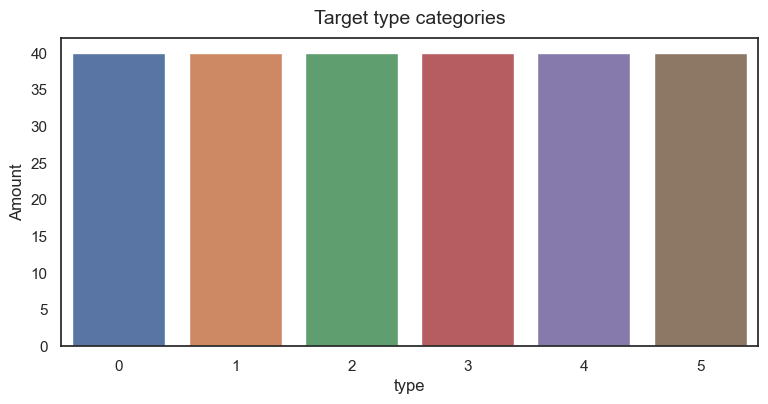


Target statistics:


,type
count,240.000000
mean,2.500000
std,1.711394
min,0.000000
25%,1.000000
50%,2.500000
75%,4.000000
max,5.000000


In [9]:
create_visualization(data=data, dtype="target", target="type",
                     is_cat_target=True, figsize=(9, 4))

Visualization of quantitative features distribution:

Feature: temperature


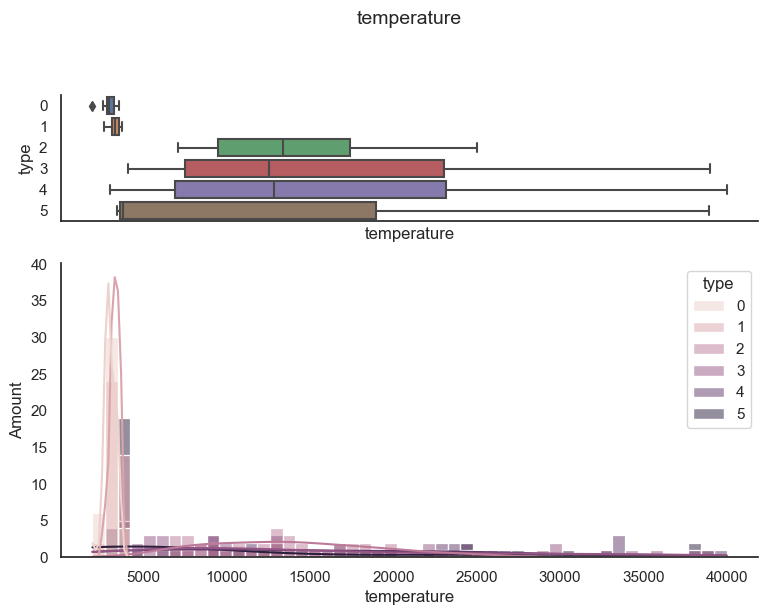


Feature statistics:


,temperature
count,240.00
mean,10497.46
std,9552.43
min,1939.00
25%,3344.25
50%,5776.00
75%,15055.50
max,40000.00


In [10]:
create_visualization(data=data[["temperature", "type"]], dtype="scalars",
                     target="type", is_cat_target=True, figsize=(9, 6))

Visualization of quantitative features distribution:

Feature: luminosity


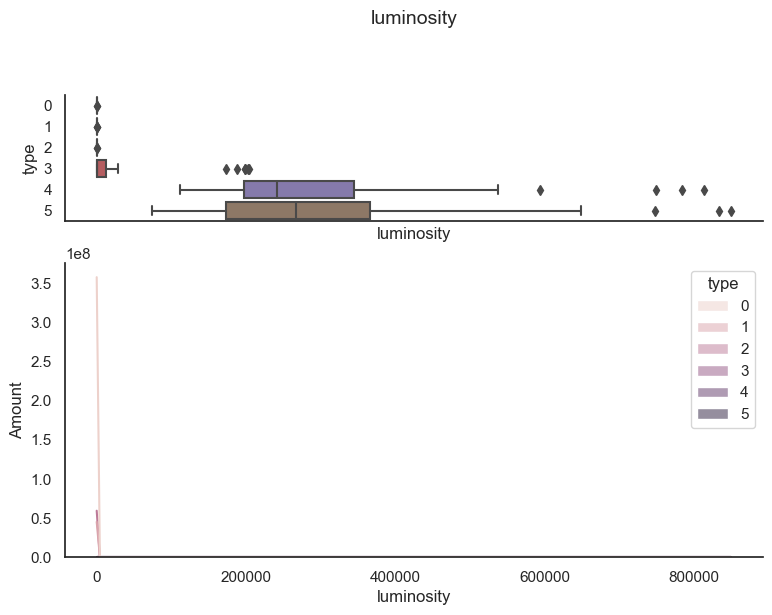


Feature statistics:


,luminosity
count,240.00
mean,107188.36
std,179432.19
min,0.00
25%,0.00
50%,0.07
75%,198050.00
max,849420.00


In [11]:
create_visualization(data=data[["luminosity", "type"]], dtype="scalars",
                     target="type", is_cat_target=True, figsize=(9, 6))

Visualization of quantitative features distribution:

Feature: radius


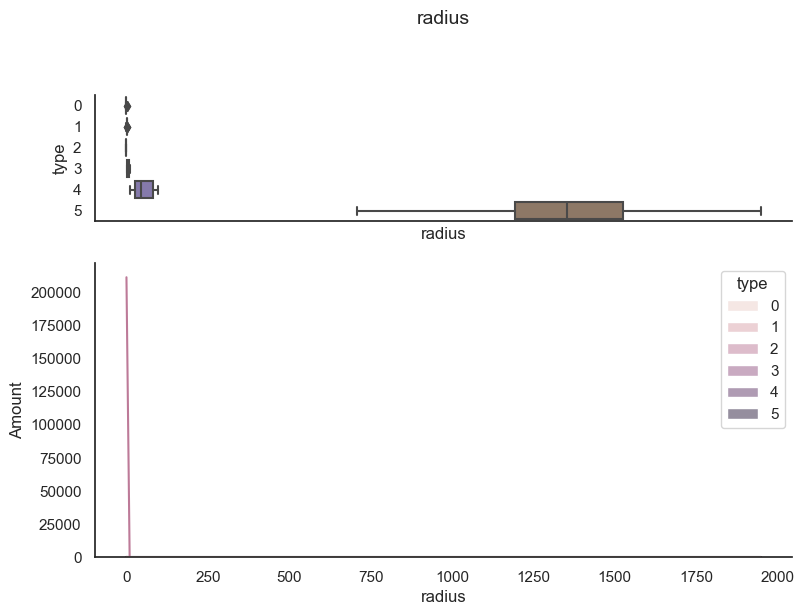


Feature statistics:


,radius
count,240.00
mean,237.25
std,inf
min,0.01
25%,0.10
50%,0.76
75%,42.75
max,1948.00


In [12]:
create_visualization(data=data[["radius", "type"]], dtype="scalars",
                     target="type", is_cat_target=True, figsize=(9, 6))

Visualization of quantitative features distribution:

Feature: magnitude


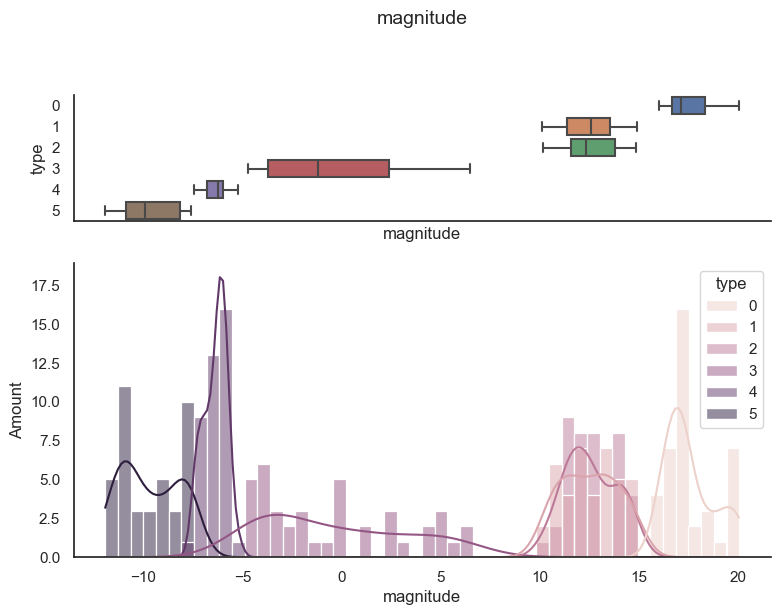


Feature statistics:


,magnitude
count,240.00
mean,4.38
std,10.53
min,-11.92
25%,-6.23
50%,8.31
75%,13.70
max,20.06


In [13]:
create_visualization(data=data[["magnitude", "type"]], dtype="scalars",
                     target="type", is_cat_target=True, figsize=(9, 6))

Visualization of categorical features and target prevalence:

Feature: color


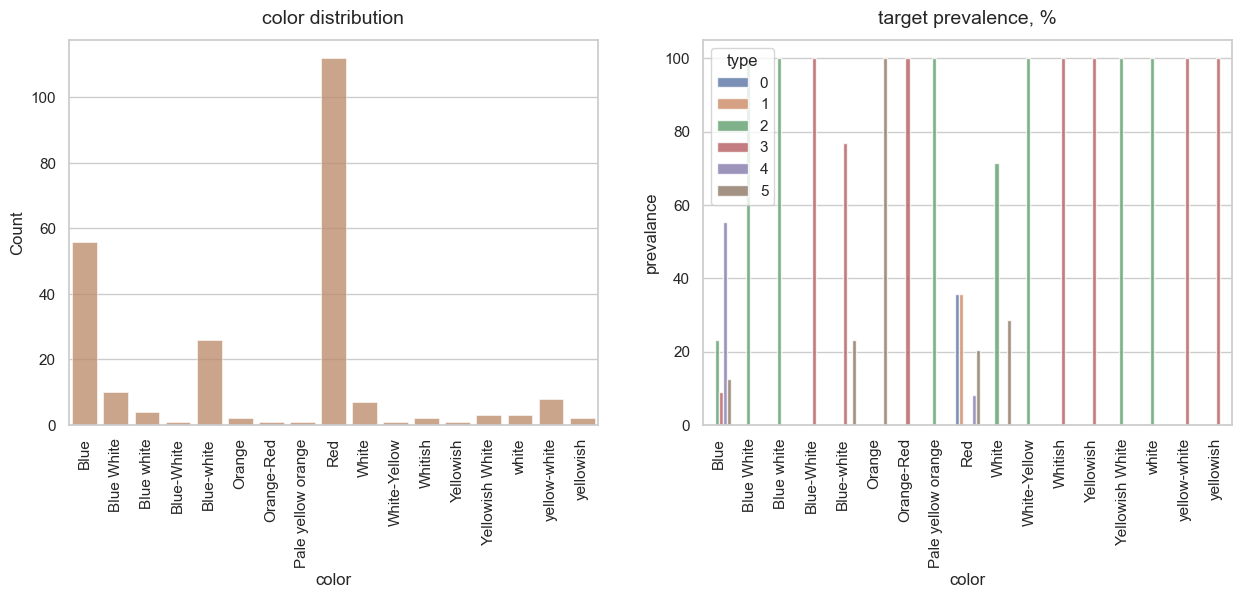

In [14]:
create_visualization(data=data[["color", "type"]], dtype="categories",
                     target="type", is_cat_target=True, figsize=(15, 5))

## Построение базовой нейронной сети

## Улучшение нейронной сети

## Выводы